In [1]:
%pip install numpy pandas geopandas matplotlib statsmodels libpysal spreg esda

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import statistics as stats
import numpy as np 
from matplotlib.lines import Line2D


# Merge of dataset

In [ ]:
listing = "dataset/listings.csv.gz"     
calendar = "dataset/calendar.csv.gz"
review = "dataset/reviews.csv.gz"
dataset = "dataset/dataset.csv"

# listings
cols = ["id","calculated_host_listings_count","latitude","longitude","room_type"]
L = pd.read_csv(listing, usecols=cols, compression="infer", low_memory=False)

# calendar 
C = pd.read_csv(calendar, usecols=["listing_id","price"], compression="infer", low_memory=False)
p = C["price"].astype(str).str.replace(r"[^\d,.\-]", "", regex=True)
p = p.map(lambda x: x.replace(",", ".") if ("," in x and "." not in x) else x.replace(",", ""))

C["price"] = pd.to_numeric(p, errors="coerce")
price = C.groupby("listing_id", as_index=False)["price"].median().rename(columns={"listing_id":"id"})

# reviews 
R = pd.read_csv(review, usecols=["listing_id","date"], compression="infer", low_memory=False, parse_dates=["date"])
start = pd.Timestamp("2024-09-17")
end   = pd.Timestamp("2024-12-20")
mask = (R["date"] >= start) & (R["date"] <= end)
reviews = (R.loc[mask]
             .groupby("listing_id")
             .size()
             .rename("n_reviews_time_window")
             .reset_index()
             .rename(columns={"listing_id":"id"}))

# merge 
out = (L.merge(price, on="id", how="left")
        .merge(reviews, on="id", how="left"))

out["n_reviews_time_window"] = out["n_reviews_time_window"].fillna(0).astype("Int64")

out.to_csv(dataset, index=False)


# Check


In [4]:
path = "dataset/dataset.csv"
df = pd.read_csv(path)  
df.head(5)


,id,latitude,longitude,room_type,calculated_host_listings_count,price,n_reviews_time_window
0,46352,44.49163,11.33398,Private room,2,42.0,13
1,59697,44.48817,11.34124,Private room,2,50.0,0
2,85368,44.47888,11.35625,Entire home/apt,1,120.0,2
3,219878,44.48787,11.35392,Entire home/apt,2,140.0,6
4,229114,44.51072,11.34957,Entire home/apt,1,90.0,4


# Geojson dataset 

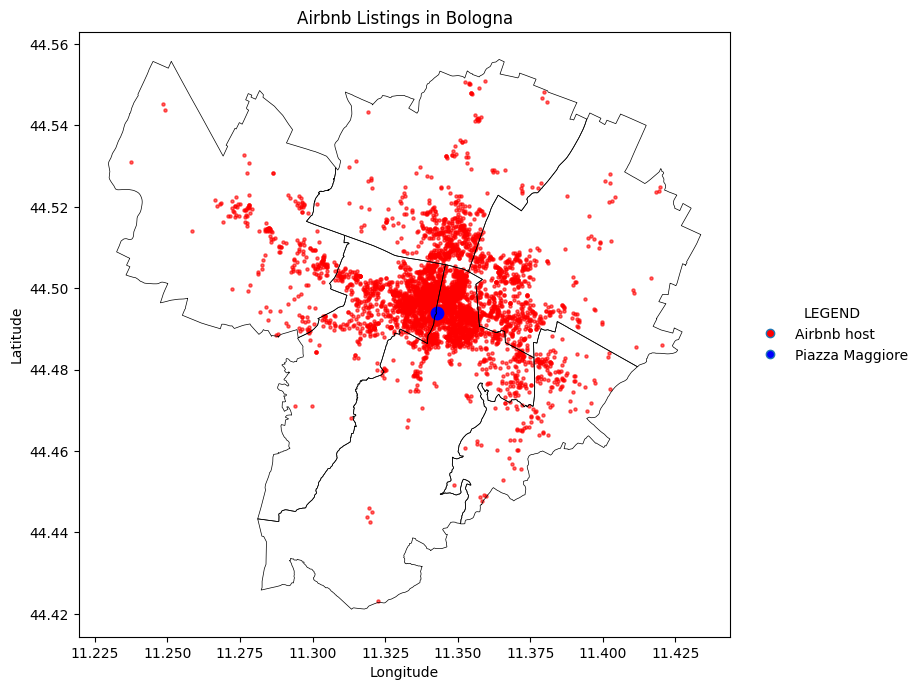

In [5]:
neigh = gpd.read_file("dataset/neighbourhoods.geojson")
gdf = gpd.GeoDataFrame(
    df.dropna(subset=["longitude","latitude"]),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)
piazza = gpd.GeoDataFrame(geometry=[Point(11.3430, 44.4939)], crs="EPSG:4326")

# Reproject to a metric CRS for Bologna (UTM 32N) to get meters
metric_crs = "EPSG:32632"
gdf_m = gdf.to_crs(metric_crs)
piazza_m = piazza.to_crs(metric_crs).iloc[0].geometry

# Distanza in km
gdf["distance_to_center_km"] = gdf_m.geometry.distance(piazza_m) / 1000.0


# Plot
ax = neigh.boundary.plot(figsize=(9, 8), color="black", linewidth=0.5)
gdf.plot(ax=ax, color="red", markersize=5, alpha=0.6)
piazza.plot(ax=ax, color="blue", markersize=80)

# Legend
ax.legend(
    handles=[
        Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='red', label='Airbnb host'),
        Line2D([0],[0], marker='o', linestyle='None', markerfacecolor='blue', label='Piazza Maggiore'),
    ],
    title="LEGEND", loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False
)

ax.set_title("Airbnb Listings in Bologna")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


# Thresholding e variables addition 

In [6]:

df["host_class"] = np.select(
    [
        df["calculated_host_listings_count"] == 1,
        (df["calculated_host_listings_count"] >= 2) & (df["calculated_host_listings_count"] <= 5),
        df["calculated_host_listings_count"] > 5
    ],
    ["single", "multi", "business"],
    default="unknown"
)


df["distance"] = gdf["distance_to_center_km"] 



# STATISTICS 

In [7]:
total = len(df)
print("Number of hosts:", total)

dup_rows = df.duplicated(subset=["id"], keep=False).sum()
perc = (dup_rows / total) * 100 if total > 0 else 0
print(f"Rows with duplicated id: {dup_rows}  ({perc:.2f}%)")


Number of hosts: 4668
Rows with duplicated id: 0  (0.00%)


In [8]:
total = len(df)

print("Missing values per column:")
for col in df.columns:
    missing = df[col].isna().sum()      
    perc = (missing / total) * 100 if total > 0 else 0
    print(f"{col:30} {missing:6}  ({perc:5.2f}%)")

print("\nNO MISSING VALUES")

Missing values per column:
id                                  0  ( 0.00%)
latitude                            0  ( 0.00%)
longitude                           0  ( 0.00%)
room_type                           0  ( 0.00%)
calculated_host_listings_count      0  ( 0.00%)
price                               0  ( 0.00%)
n_reviews_time_window               0  ( 0.00%)
host_class                          0  ( 0.00%)
distance                            0  ( 0.00%)

NO MISSING VALUES


Room types:
Entire home/apt        3646  (78.11%)
Private room           1010  (21.64%)
Hotel room                6  ( 0.13%)
Shared room               6  ( 0.13%)


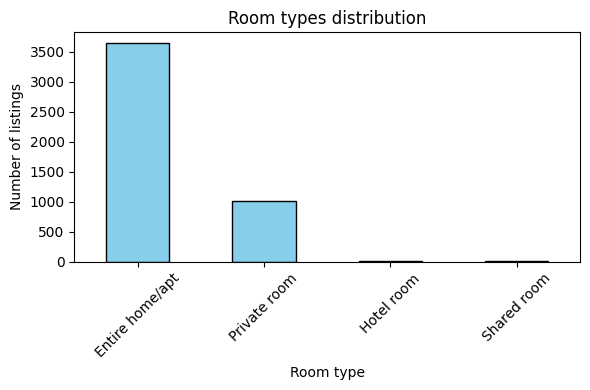

In [9]:
room_counts = df["room_type"].value_counts()

print("Room types:")
for rt, cnt in room_counts.items():
    perc = (cnt / total) * 100 if total > 0 else 0
    print(f"{rt:20} {cnt:6}  ({perc:5.2f}%)")

plt.figure(figsize=(6,4))
room_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Room types distribution")
plt.xlabel("Room type")
plt.ylabel("Number of listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of listing counts :
 Min: 1
 Max: 168
 Mean: 15.557412167952014
 Std: 34.93794926142875


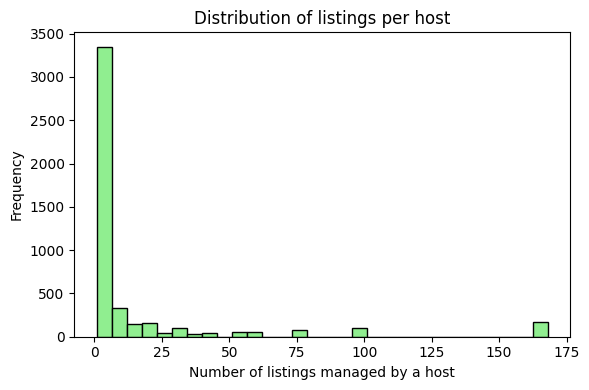

In [ ]:
print("Number of listing counts :")
print(" Min:", min(df["calculated_host_listings_count"]))
print(" Max:", max(df["calculated_host_listings_count"]))
print(" Mean:", stats.mean(df["calculated_host_listings_count"]))
print(" Std:", stats.stdev(df["calculated_host_listings_count"]))



plt.figure(figsize=(6,4))
plt.hist(df["calculated_host_listings_count"], bins=30, color="lightgreen", edgecolor="black")
plt.title("Distribution of listings per host")
plt.xlabel("Number of listings managed by a host")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Price stats:
 Min: 10.0
 Max: 9999.0
 Median: 99.0
 Mean: 211.51113967437874
 Std: 620.2425761868667


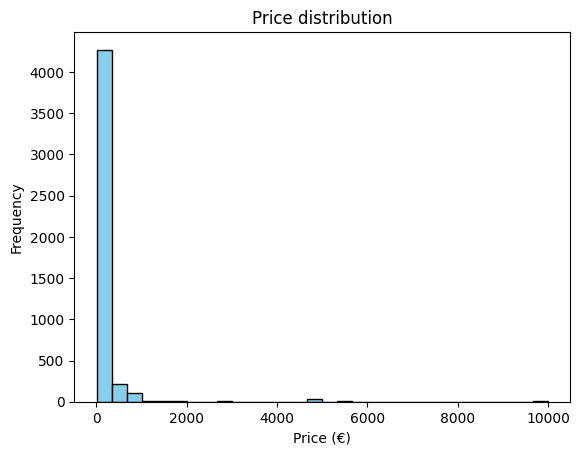

In [ ]:
print("Price stats:")
print(" Min:", min(df["price"]))
print(" Max:", max(df["price"]))
print(" Median:", stats.median(df["price"]))
print(" Mean:", stats.mean(df["price"]))
print(" Std:", stats.stdev(df["price"]))

plt.hist(df["price"], bins=30, color="skyblue", edgecolor="black")
plt.title("Price distribution")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.show()

Reviews stats:
 Min: 0
 Max: 42
 Mean: 3.872750642673522
 Std: 5.523900848421347


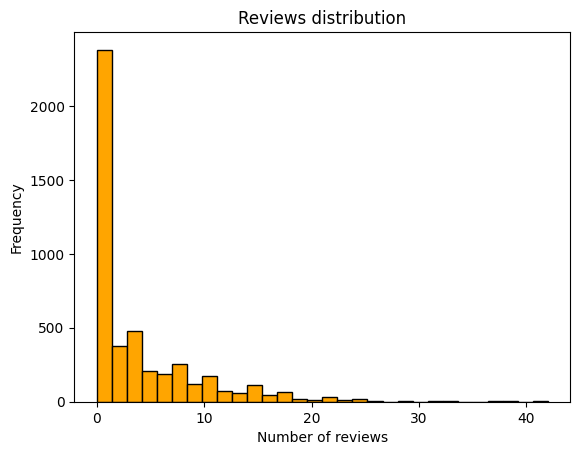

In [ ]:
print("Reviews stats:")
print(" Min:", min(df["n_reviews_time_window"]))
print(" Max:", max(df["n_reviews_time_window"]))
print(" Mean:", stats.mean(df["n_reviews_time_window"]))
print(" Std:", stats.stdev(df["n_reviews_time_window"]))

plt.hist(df["n_reviews_time_window"], bins=30, color="orange", edgecolor="black")
plt.title("Reviews distribution")
plt.xlabel("Number of reviews")
plt.ylabel("Frequency")
plt.show()

Host classes:
single       1740  (37.28%)
business     1524  (32.65%)
multi        1404  (30.08%)


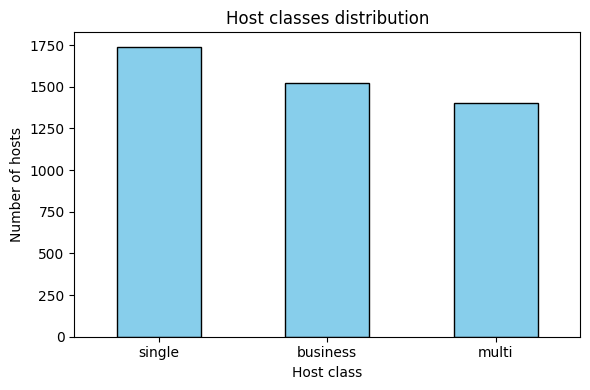

In [13]:
total_hosts = len(df)

print("Host classes:")
for cls, cnt in df["host_class"].value_counts().items():
    perc = (cnt / total_hosts) * 100 if total_hosts > 0 else 0
    print(f"{cls:10} {cnt:6}  ({perc:5.2f}%)")


plt.figure(figsize=(6,4))
df["host_class"].value_counts().plot(
    kind="bar",
    color="skyblue",
    edgecolor="black"
)
plt.title("Host classes distribution")
plt.xlabel("Host class")
plt.ylabel("Number of hosts")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# No need data removal 

In [14]:
df = df.drop(columns=["calculated_host_listings_count"])
df["reviews"] = np.log1p(df["n_reviews_time_window"])
df = df.drop(columns=["n_reviews_time_window"])
df["price"] = np.log(df["price"])

# Final dataset

In [15]:
df.head(5)
df.to_csv("dataset/dataset.csv")